In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import permutation_importance

## Data Preprocessing and Cleaning (same for both models NN and Ridge Regression)

In [2]:
# Load the dataset
data = pd.read_csv("day.csv")

# Drop unnecessary features
data = data.drop(columns=["atemp", "instant", "mnth", "dteday", "holiday", "weekday", "windspeed", "registered", "casual"])

# One-hot encode categorical variables
data = pd.get_dummies(data, columns=["season", "weathersit"], drop_first=True)

# Function to remove outliers
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)  # First quartile
    Q3 = df[column].quantile(0.75)  # Third quartile
    IQR = Q3 - Q1  # Interquartile range
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Filter rows that are within the bounds
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Remove outliers for each numeric feature
numeric_features = ["temp", "hum", "cnt"]
for feature in numeric_features:
    data = remove_outliers(data, feature)

X = data.drop(columns=["cnt"]) # features
y = data['cnt']  # target

# Scale and normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# # Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

## Model Training

In [3]:
mlp = MLPRegressor(
    hidden_layer_sizes=(128, 64, 32),
    activation="relu",
    solver="adam",
    learning_rate_init=0.01,
    max_iter=5000,
    random_state=42,
    validation_fraction=0.2,
    tol = 1e-6,
    verbose=True
)

# train model
mlp.fit(X_train, y_train)

Iteration 1, loss = 12470444.08092753
Iteration 2, loss = 12442819.63397656
Iteration 3, loss = 12369661.40822682
Iteration 4, loss = 12209966.91737700
Iteration 5, loss = 11901166.63119100
Iteration 6, loss = 11357465.48451710
Iteration 7, loss = 10459542.06030188
Iteration 8, loss = 9083066.28993999
Iteration 9, loss = 7199796.54944476
Iteration 10, loss = 4781951.96824012
Iteration 11, loss = 2333910.02318649
Iteration 12, loss = 920332.06517859
Iteration 13, loss = 1398614.50325686
Iteration 14, loss = 1718533.36550706
Iteration 15, loss = 987720.13223325
Iteration 16, loss = 569314.20970082
Iteration 17, loss = 639413.82375411
Iteration 18, loss = 763775.73006871
Iteration 19, loss = 716123.90623892
Iteration 20, loss = 557989.46435111
Iteration 21, loss = 463236.79628320
Iteration 22, loss = 475672.07221380
Iteration 23, loss = 489523.70384311
Iteration 24, loss = 453085.88116388
Iteration 25, loss = 417741.37393318
Iteration 26, loss = 417344.45096321
Iteration 27, loss = 417511

MLPRegressor(hidden_layer_sizes=(128, 64, 32), learning_rate_init=0.01,
             max_iter=5000, random_state=42, tol=1e-06, validation_fraction=0.2,
             verbose=True)

## R² and MSE

In [4]:
# Predict on the test set
y_pred = mlp.predict(X_test)

# Evaluate the performance with regression metrics
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"R-squared (R²) on the test set: {r2:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")

R-squared (R²) on the test set: 0.86
Mean Squared Error (MSE): 505593.84


## Performance Plots


### 1. Predicted vs. Actual

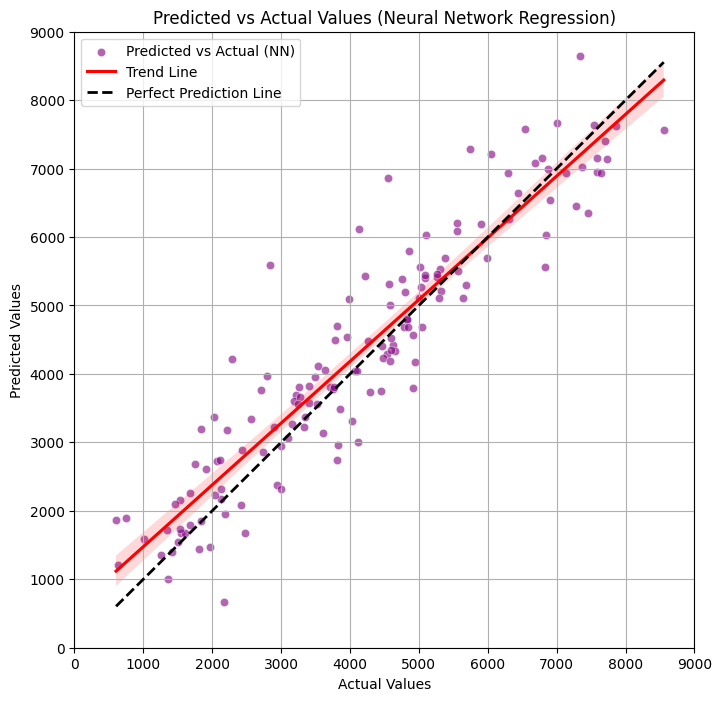

In [5]:
plt.figure(figsize=(8, 8))

# scatter plot
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, color="purple", label="Predicted vs Actual (NN)")

# regression trend line
sns.regplot(x=y_test, y=y_pred, scatter=False, color="red", label="Trend Line")

# perfect prediction line
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "k--", lw=2, label="Perfect Prediction Line")

# making plot readable
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs Actual Values (Neural Network Regression)")
plt.legend()
plt.grid(True)

# consistent scale
plt.xlim([0, 9000])
plt.ylim([0, 9000])

plt.show()

### 2. Normalized Feature Importance

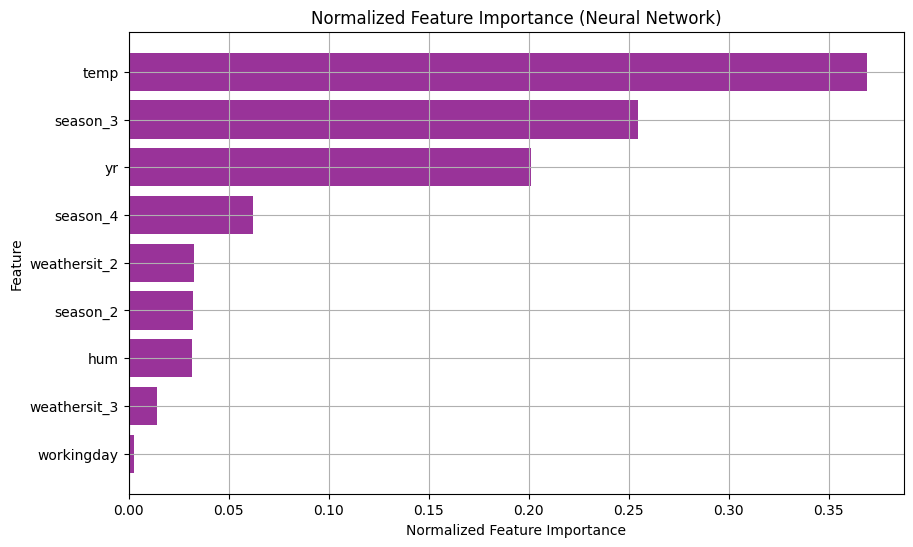

In [6]:
# compute Permutation Importance
perm_importance = permutation_importance(mlp, X_test, y_test, n_repeats=10, random_state=42)

# Normalize the importance scores
importances_mean = perm_importance.importances_mean
normalized_importance = importances_mean / importances_mean.sum()  # Normalize to sum to 1

# Extract feature importance and sort them
sorted_idx = normalized_importance.argsort()

# Plot Normalized Feature Importance
plt.figure(figsize=(10, 6))
plt.barh(np.array(data.drop(columns=["cnt"]).columns)[sorted_idx], normalized_importance[sorted_idx], color='purple', alpha=0.8)
plt.xlabel("Normalized Feature Importance")
plt.ylabel("Feature")
plt.title("Normalized Feature Importance (Neural Network)")
plt.grid(True)
plt.show()

### 3. Residual Plot

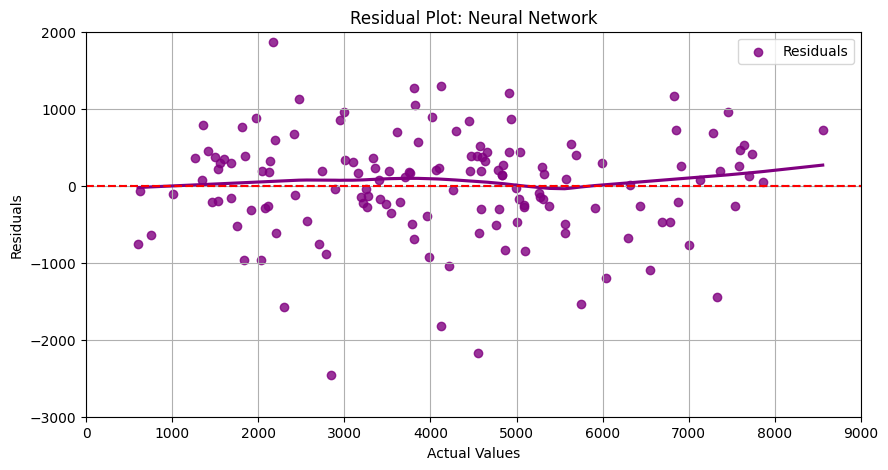

In [7]:
# Calculate residuals
residuals = y_test - y_pred

plt.figure(figsize=(10, 5))

# Residual plot: Visualize residuals as a function of actual values
# 'lowess=True' adds a locally weighted regression line to show the trend in residuals
sns.residplot(x=y_test, y=residuals, lowess=True, color="purple", label="Residuals")

# Add a horizontal line at 0 to represent no residual (perfect prediction)
plt.axhline(0, color='red', linestyle='--', linewidth=1.5)

# making plot readable
plt.title("Residual Plot: Neural Network")
plt.xlabel("Actual Values")
plt.ylabel("Residuals")
plt.legend()
plt.grid(True)

# consistent scale
plt.xlim([0, 9000])
plt.ylim([-3000, 2000])

plt.show()

### 4. Distribution of Residuals

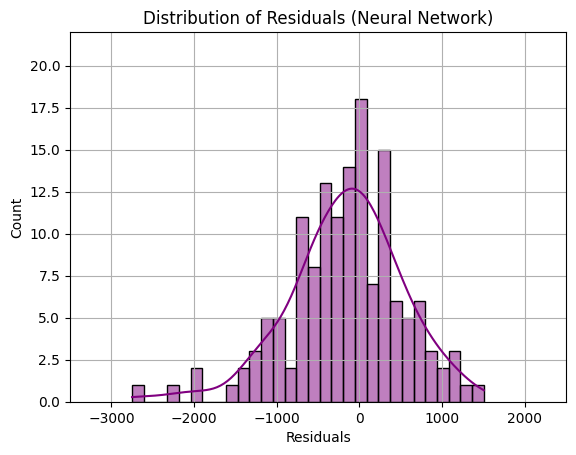

In [8]:
# sns.histplot creates a histogram of residual values with a KDE (Kernel Density Estimate) overlay
sns.histplot(residuals, kde=True, color="purple", bins=30)

# making plot readable
plt.xlabel("Residuals")
plt.title("Distribution of Residuals (Neural Network)")
plt.grid(True)

# consistent scale
plt.xlim([-3500, 2500])
plt.ylim([0.0, 22.0])

plt.show()

### 5. Loss Function Curve

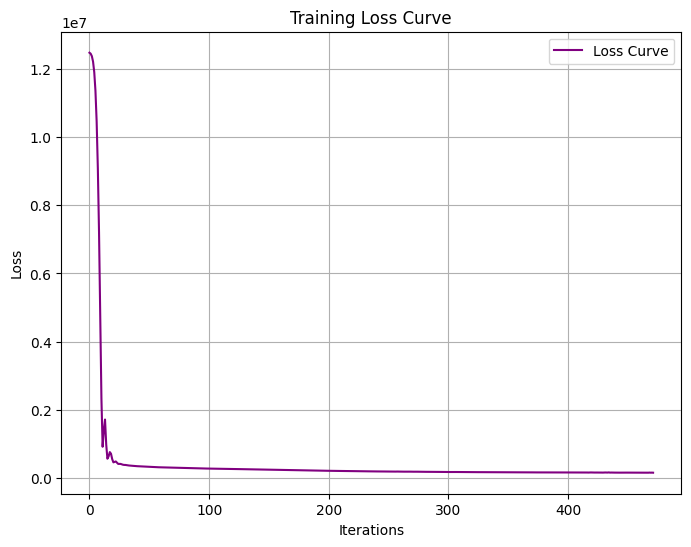

In [9]:
plt.figure(figsize=(8, 6))

# plot the loss curve using the `mlp.loss_curve_` attribute
plt.plot(mlp.loss_curve_, label="Loss Curve", color="purple")

# making plot readable
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.grid(True)
plt.legend()

plt.show()